# Clustering

In [ ]:
import torch
import matplotlib.pyplot as plt

In [ ]:
torch.manual_seed(1103)
torch.set_printoptions(precision=2, linewidth=160, sci_mode=False)

## Create data

In [ ]:
n_clusters = 6
n_samples = 300

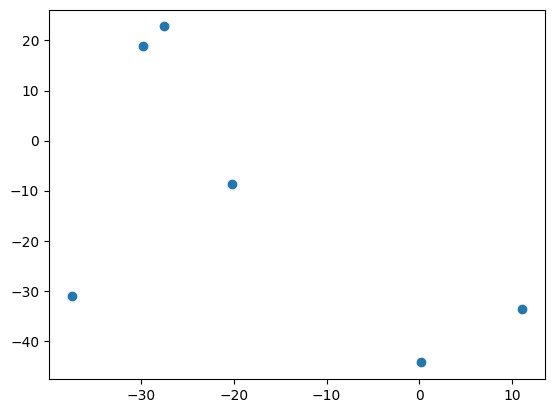

In [ ]:
scale = 90
centroids = torch.rand(n_clusters, 2) * scale - scale / 2
plt.scatter(centroids[:, 0], centroids[:, 1])
plt.show()

In [ ]:
centroid = centroids[0]

In [ ]:
dist = torch.distributions.multivariate_normal.MultivariateNormal(centroid, torch.diag(torch.tensor([2., 3.])))
cluster = dist.sample((n_samples,))
cluster.shape

torch.Size([300, 2])

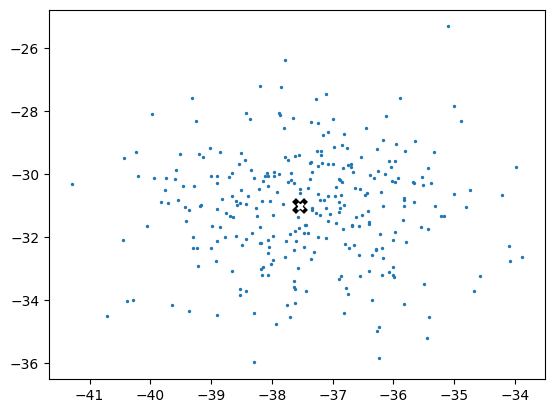

In [ ]:
plt.scatter(cluster[:, 0], cluster[:, 1], s=2)
plt.plot(*centroid, marker="x", color="black", markersize=8, mew=4)
plt.plot(*centroid, marker="x", color="white", markersize=4, mew=2)
plt.show()

In [ ]:
def generate_cluster(centroid):
    dist = torch.distributions.multivariate_normal.MultivariateNormal(centroid, torch.diag(torch.tensor([2., 3.])))
    return dist.sample((n_samples,))

In [ ]:
clusters = torch.cat(
    [generate_cluster(centroid) for centroid in centroids]
)
clusters.shape

torch.Size([1800, 2])

In [ ]:
def plot_clusters(clusters, centroids, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    for i, centroid in enumerate(centroids):
        cluster = clusters[i*n_samples:(i+1)*n_samples]
        ax.scatter(cluster[:, 0], cluster[:, 1], s=2)
        ax.plot(*centroid, marker="x", color="black", markersize=8, mew=4)
        ax.plot(*centroid, marker="x", color="white", markersize=4, mew=2)

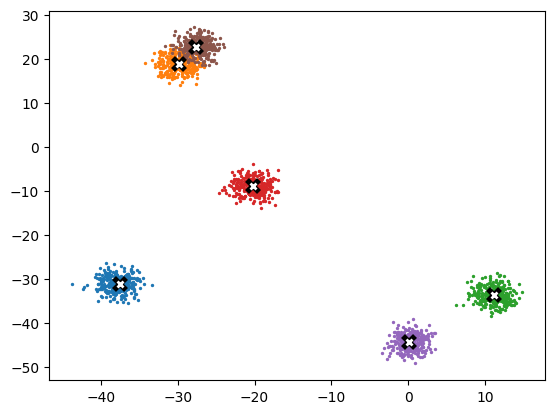

In [ ]:
plot_clusters(clusters, centroids)

## Mean shift

In [ ]:
import math

In [ ]:
def gaussian(d, bw):
    return torch.exp(-0.5 * (d/bw)**2) / (bw * math.sqrt(2 * math.pi))
    

In [ ]:
gaussian(torch.tensor(3), torch.tensor(3))

tensor(0.08)

In [ ]:
def plot_func(f):
    xs = torch.linspace(0, 20, 100)
    plt.plot(xs, f(xs))

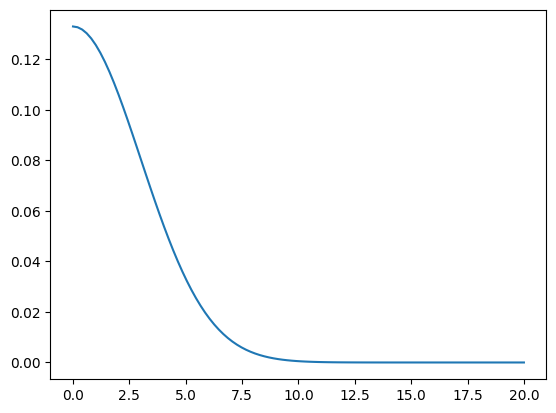

In [ ]:
plot_func(lambda d: gaussian(d, 3))

In [ ]:
def tri(d, i):
    return torch.clamp_min(-d + i, 0) / i

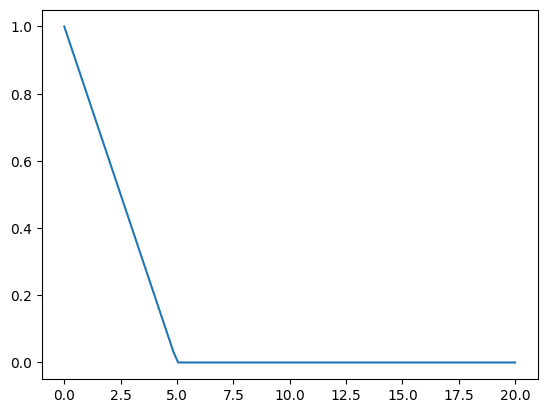

In [ ]:
plot_func(lambda d: tri(d, 5))

In [ ]:
data = clusters.clone()

In [ ]:
p = data[0]
p

tensor([-38.17, -33.65])

In [ ]:
data.shape, p.shape

(torch.Size([1800, 2]), torch.Size([2]))

In [ ]:
distances = ((data - p)**2).sum(dim=1).sqrt()

In [ ]:
a = torch.tensor([[1, 2], [2, 3]])
b = torch.tensor([2, 2])

In [ ]:
a - b

tensor([[-1,  0],
        [ 0,  1]])

In [ ]:
(a - b)**2

tensor([[1, 0],
        [0, 1]])

In [ ]:
((a - b)**2).sum(dim=1).sqrt()

tensor([1., 1.])

In [ ]:
diff = a - b
torch.einsum("ij,ij->i", diff, diff).sqrt()

tensor([1., 1.])

In [ ]:
diff = data - p
dist = torch.einsum("ij,ij->i", diff, diff).sqrt()

In [ ]:
from fastcore.test import *

In [ ]:
test_close(distances, dist)

In [ ]:
weights = gaussian(dist, 2.)

In [ ]:
weights.shape, data.shape

(torch.Size([1800]), torch.Size([1800, 2]))

In [ ]:
new = (weights[:, None] * data).sum(0) / weights.sum()
new, p

(tensor([-37.91, -32.12]), tensor([-38.17, -33.65]))

In [ ]:
def one_update(X):
    for i, p in enumerate(X):
        diff = X - p
        dist = torch.einsum("ij,ij->i", diff, diff).sqrt()
        weights = gaussian(dist, 2.)
        X[i] = (weights[:, None] * X).sum(0) / weights.sum()

In [ ]:
def meanshift(X):
    X = X.clone()
    for i in range(5):
        one_update(X)
    return X

In [ ]:
predicted = meanshift(data)

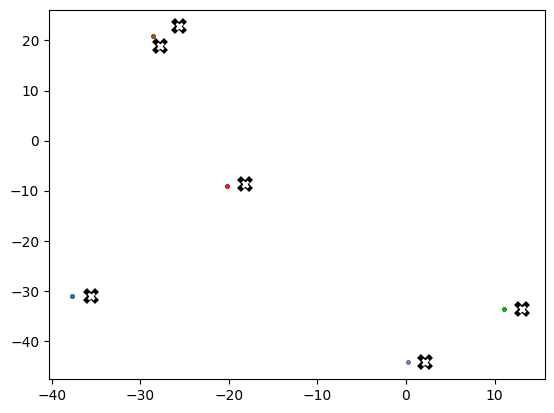

In [ ]:
plot_clusters(predicted, centroids + torch.tensor([2, 0]))

In [ ]:
%time _=meanshift(data)

CPU times: user 1.51 s, sys: 25.6 ms, total: 1.54 s
Wall time: 1.52 s


In [ ]:
def one_update(X):
    for i, p in enumerate(X):
        diff = data - p
        dist = torch.einsum("ij,ij->i", diff, diff).sqrt()
        weights = tri(dist, 2.)
        X[i] = (weights[:, None] * X).sum(0) / weights.sum()

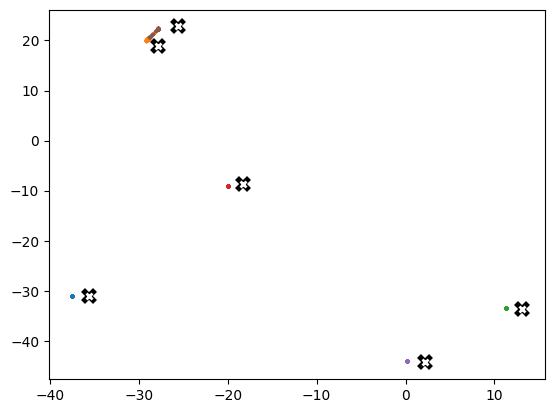

In [ ]:
predicted = meanshift(data)
plot_clusters(predicted, centroids + torch.tensor([2, 0]))

In [ ]:
%time _=meanshift(data)

CPU times: user 1.05 s, sys: 18 ms, total: 1.07 s
Wall time: 1.04 s


### update all at once

In [ ]:
def one_update_at_once(X):
    new = torch.empty(X.shape)
    for i, p in enumerate(X):
        diff = X - p
        dist = torch.einsum("ij,ij->i", diff, diff).sqrt()
        weights = gaussian(dist, 2.)
        new[i] = (weights[:, None] * X).sum(0) / weights.sum()
    return new

def meanshift_at_once(X):
    X = X.clone()
    for i in range(5):
        X = one_update_at_once(X)
    return X

In [ ]:
predicted = meanshift_at_once(data)

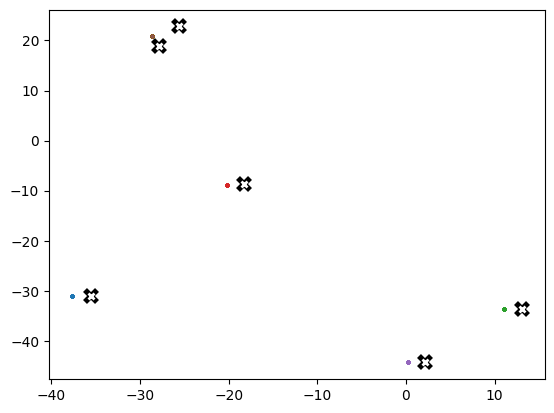

In [ ]:
plot_clusters(predicted, centroids + torch.tensor([2, 0]))

## Animation

In [ ]:
def do_one(d):
    if d:
        one_update(X)
    ax.clear()
    plot_clusters(X, centroids + torch.tensor([2, 0]), ax)

In [ ]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [ ]:
FuncAnimation?

Init signature:
FuncAnimation(
    fig,
    func,
    frames=None,
    init_func=None,
    fargs=None,
    save_count=None,
    *,
    cache_frame_data=True,
    **kwargs,
)
Docstring:     
`TimedAnimation` subclass that makes an animation by repeatedly calling
a function *func*.

.. note::

    You must store the created Animation in a variable that lives as long
    as the animation should run. Otherwise, the Animation object will be
    garbage-collected and the animation stops.

Parameters
----------
fig : `~matplotlib.figure.Figure`
    The figure object used to get needed events, such as draw or resize.

func : callable
    The function to call at each frame.  The first argument will
    be the next value in *frames*.   Any additional positional
    arguments can be supplied using `functools.partial` or via the *fargs*
    parameter.

    The required signature is::

        def func(frame, *fargs) -> iterable_of_artists

    It is often more convenient to provide the arguments u

In [ ]:
X = data.clone()
fig, ax = plt.subplots()
anim = FuncAnimation(fig, do_one, frames=5, interval=1000, repeat=False)
plt.close()
HTML(anim.to_jshtml())

In [ ]:
def do_one(d):
    global X
    if d:
        X = one_update_at_once(X)
    ax.clear()
    plot_clusters(X, centroids + torch.tensor([2, 0]), ax)

X = data.clone()
fig, ax = plt.subplots()
anim = FuncAnimation(fig, do_one, frames=5, interval=1000, repeat=False)
plt.close()
HTML(anim.to_jshtml())

## GPU batched algorithm

In [ ]:
batch = data[:5]
batch.shape

torch.Size([5, 2])

In [ ]:
data.shape, batch.shape

(torch.Size([1800, 2]), torch.Size([5, 2]))

In [ ]:
data[:, None].shape, batch[None].shape

(torch.Size([1800, 1, 2]), torch.Size([1, 5, 2]))

In [ ]:
diff = data[:, None] - batch[None]
diff.shape

torch.Size([1800, 5, 2])

In [ ]:
distb = torch.einsum("ibd,ibd->ib", diff, diff).sqrt()

In [ ]:
test_close(((data - data[0])**2).sum(dim=1).sqrt(), distb[:, 0])
test_close(((data - data[3])**2).sum(dim=1).sqrt(), distb[:, 3])

In [ ]:
def dist_b(a, b):
    diff = a[:, None] - b[None]
    return torch.einsum("ibd,ibd->ib", diff, diff).sqrt()

In [ ]:
distb = dist_b(data, batch)

In [ ]:
weightsb = gaussian(distb, 2)

In [ ]:
data.shape, weightsb.shape

(torch.Size([1800, 2]), torch.Size([1800, 5]))

In [ ]:
data[:, :, None].shape, weightsb[:, None].shape

(torch.Size([1800, 2, 1]), torch.Size([1800, 1, 5]))

In [ ]:
(data[:, :, None] * weightsb[:, None]).shape

torch.Size([1800, 2, 5])

In [ ]:
(data[:, :, None] * weightsb[:, None]).sum(0).shape

torch.Size([2, 5])

In [ ]:
weightsb.sum(0).shape

torch.Size([5])

In [ ]:
newb = ((data[:, :, None] * weightsb[:, None]).sum(0) / weightsb.sum(0)).T

In [ ]:
newb, batch

(tensor([[-37.91, -32.12],
         [-37.93, -29.20],
         [-38.30, -31.75],
         [-37.38, -30.98],
         [-36.79, -29.89]]),
 tensor([[-38.17, -33.65],
         [-38.28, -26.66],
         [-39.38, -32.74],
         [-36.75, -31.04],
         [-35.08, -28.37]]))

In [ ]:
test_close(newb[0], new)

In [ ]:
def meanshift(data, bs=500):
    X = data.clone()
    for _ in range(5):
        for i in range(0, len(data), bs):
            s = slice(i, min(i + bs, len(data)))
            batch = X[s]

            # Slow
            # distb = dist_b(X, batch)
            # weightsb = gaussian(distb, 2.)
            # X[s] = ((data[:, :, None] * weightsb[:, None]).sum(0) / weightsb.sum(0)).T

            # Still slow
            # distb = dist_b(X, batch).T
            # weightsb = gaussian(distb, 2.)
            # div = weightsb.sum(1, keepdim=True)
            # X[s] = (weightsb@X) / div

            # Fast
            distb = (((X[None]-batch[:,None])**2).sum(2)).sqrt().T
            weightsb = gaussian(distb, 2.)
            X[s] = ((data[:, :, None] * weightsb[:, None]).sum(0) / weightsb.sum(0)).T

            # Fast
            # distb = (((X[None]-batch[:,None])**2).sum(2)).sqrt()
            # weightsb = gaussian(distb, 2.)
            # div = weightsb.sum(1, keepdim=True)
            # X[s] = weightsb@X/div
            
    return X

In [ ]:
dist_b??

Signature: dist_b(a, b)
Docstring: <no docstring>
Source:   
def dist_b(a, b):
    diff = a[:, None] - b[None]
    return torch.einsum("ibd,ibd->ib", diff, diff).sqrt()
File:      /tmp/ipykernel_3903/3165050551.py
Type:      function

In [ ]:
"(((a[None]-b[:,None])**2).sum(2)).sqrt().T"

'(((a[None]-b[:,None])**2).sum(2)).sqrt().T'

In [ ]:
data_c = data.cuda()

In [ ]:
X = meanshift(data_c).cpu()

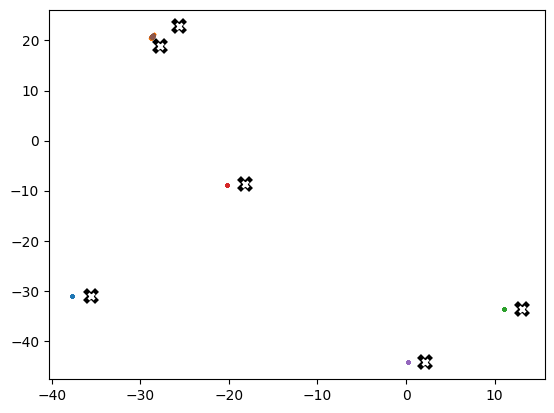

In [ ]:
plot_clusters(X, centroids + torch.tensor([2, 0]))

In [ ]:
%time _ = meanshift(data_c, bs=32).cpu()
%time _ = meanshift(data_c, bs=256).cpu()
%time _ = meanshift(data_c, bs=1024).cpu()
%time _ = meanshift(data_c, bs=1500).cpu()

CPU times: user 57.1 ms, sys: 935 µs, total: 58.1 ms
Wall time: 57.6 ms
CPU times: user 21.3 ms, sys: 0 ns, total: 21.3 ms
Wall time: 21.3 ms
CPU times: user 19.1 ms, sys: 0 ns, total: 19.1 ms
Wall time: 20.3 ms
CPU times: user 20.7 ms, sys: 0 ns, total: 20.7 ms
Wall time: 21.9 ms


In [ ]:
%time _ = meanshift(data_c, bs=1)
%time _ = meanshift(data_c, bs=32)
%time _ = meanshift(data_c, bs=256)
%time _ = meanshift(data_c, bs=1024)
%time _ = meanshift(data_c, bs=1500)

CPU times: user 1.78 s, sys: 27.2 ms, total: 1.81 s
Wall time: 1.81 s
CPU times: user 57.6 ms, sys: 0 ns, total: 57.6 ms
Wall time: 57.5 ms
CPU times: user 0 ns, sys: 9.1 ms, total: 9.1 ms
Wall time: 9.11 ms
CPU times: user 1.8 ms, sys: 527 µs, total: 2.33 ms
Wall time: 2.33 ms
CPU times: user 2.11 ms, sys: 251 µs, total: 2.36 ms
Wall time: 2.37 ms
